# Keras CV

### Install needed dependencies

In [2]:
!pip install keras-cv

In [1]:
!pip install keras==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.1 requires keras>=3.0.0, but you have keras 2.15.0 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [3]:
!pip install tensorflow --upgrade

  Using cached keras-3.1.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [4]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

## Inference with a pretrained classifier

In [5]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

100%|██████████| 99.5M/99.5M [00:01<00:00, 74.7MB/s]


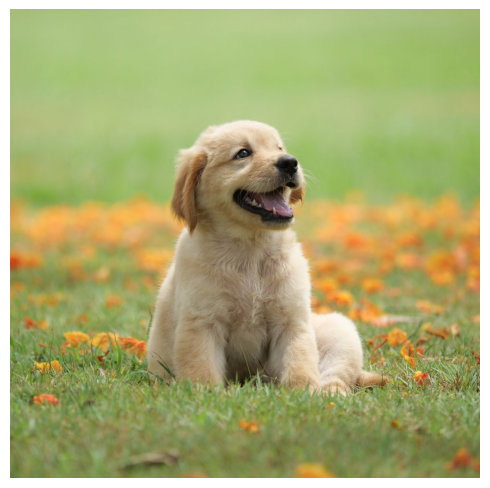

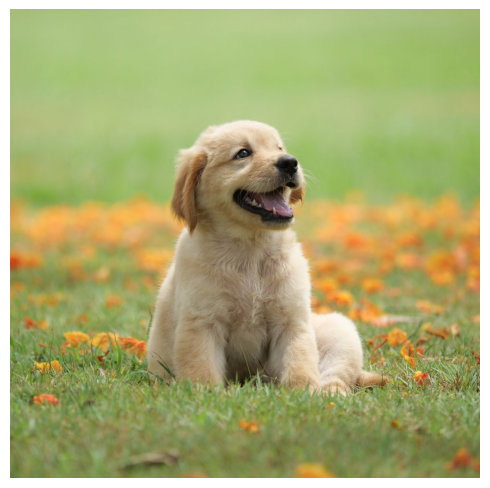

In [7]:
filepath = "/content/doggy.jpeg"
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

In [8]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

In [9]:
image_batch = inference_resizing([image])

In [10]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


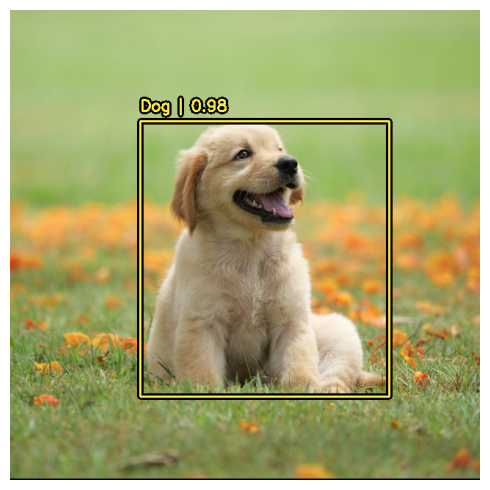

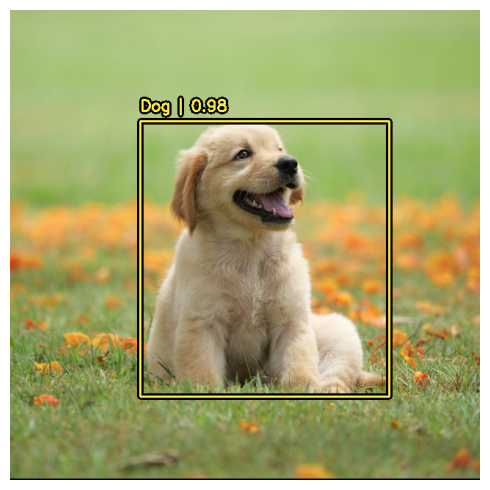

In [11]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

## Fine-tuning a pretrained backbone

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


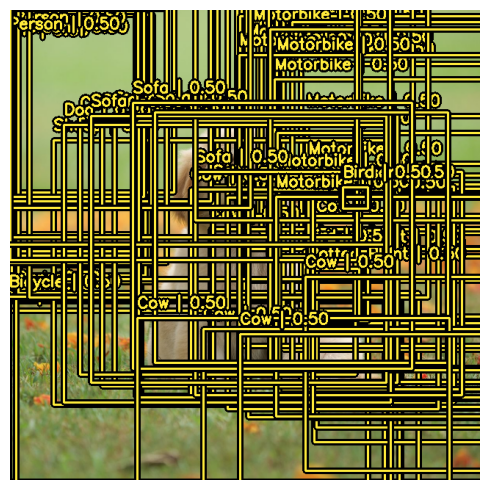

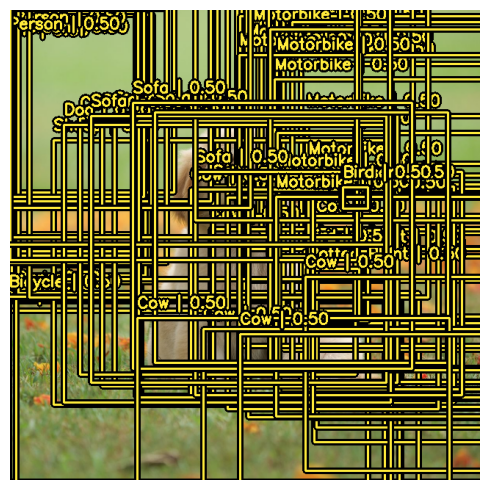

In [12]:
# The following NonMaxSuppression layer is equivalent to disabling the operation
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


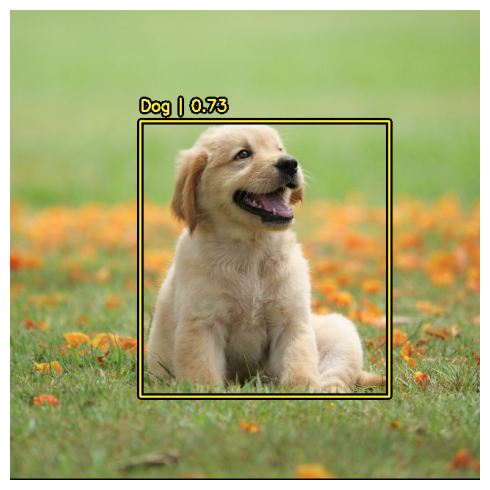

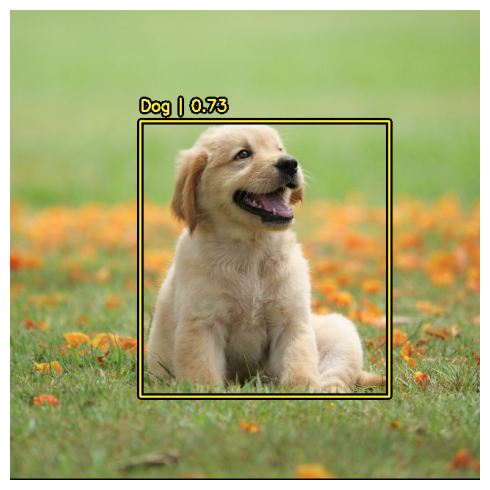

In [13]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

## Training a image classifier from scratch

In [14]:
BATCH_SIZE = 6

In [15]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds


train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(BATCH_SIZE * 6)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteZ4G0CZ/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteZ4G0CZ/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteZ4G0CZ/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [16]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

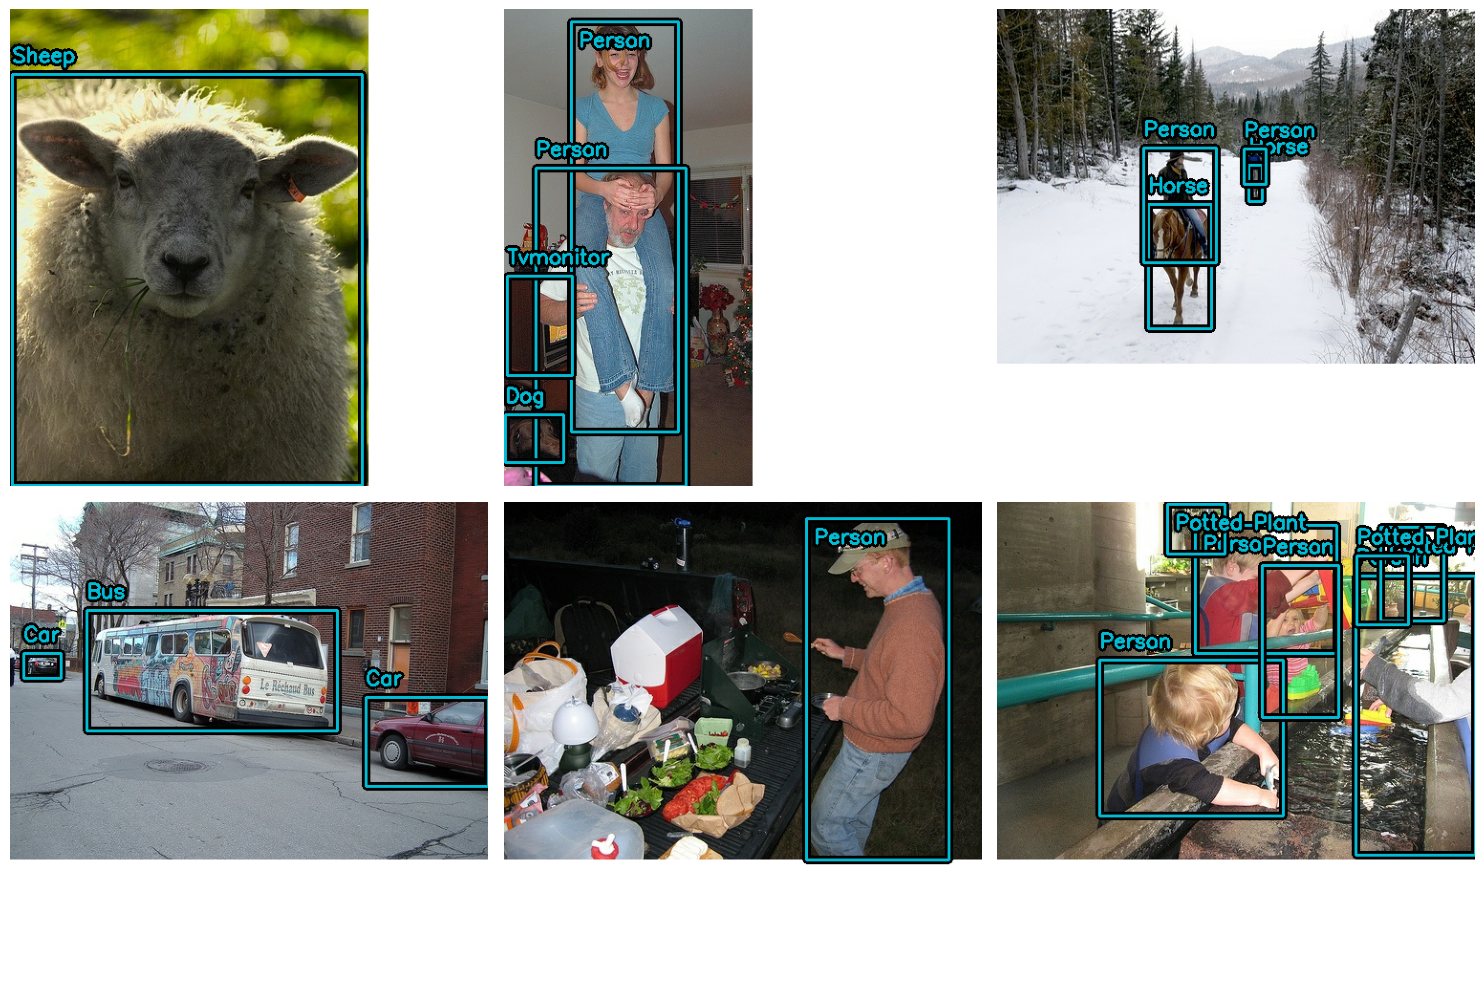

In [17]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=3
)

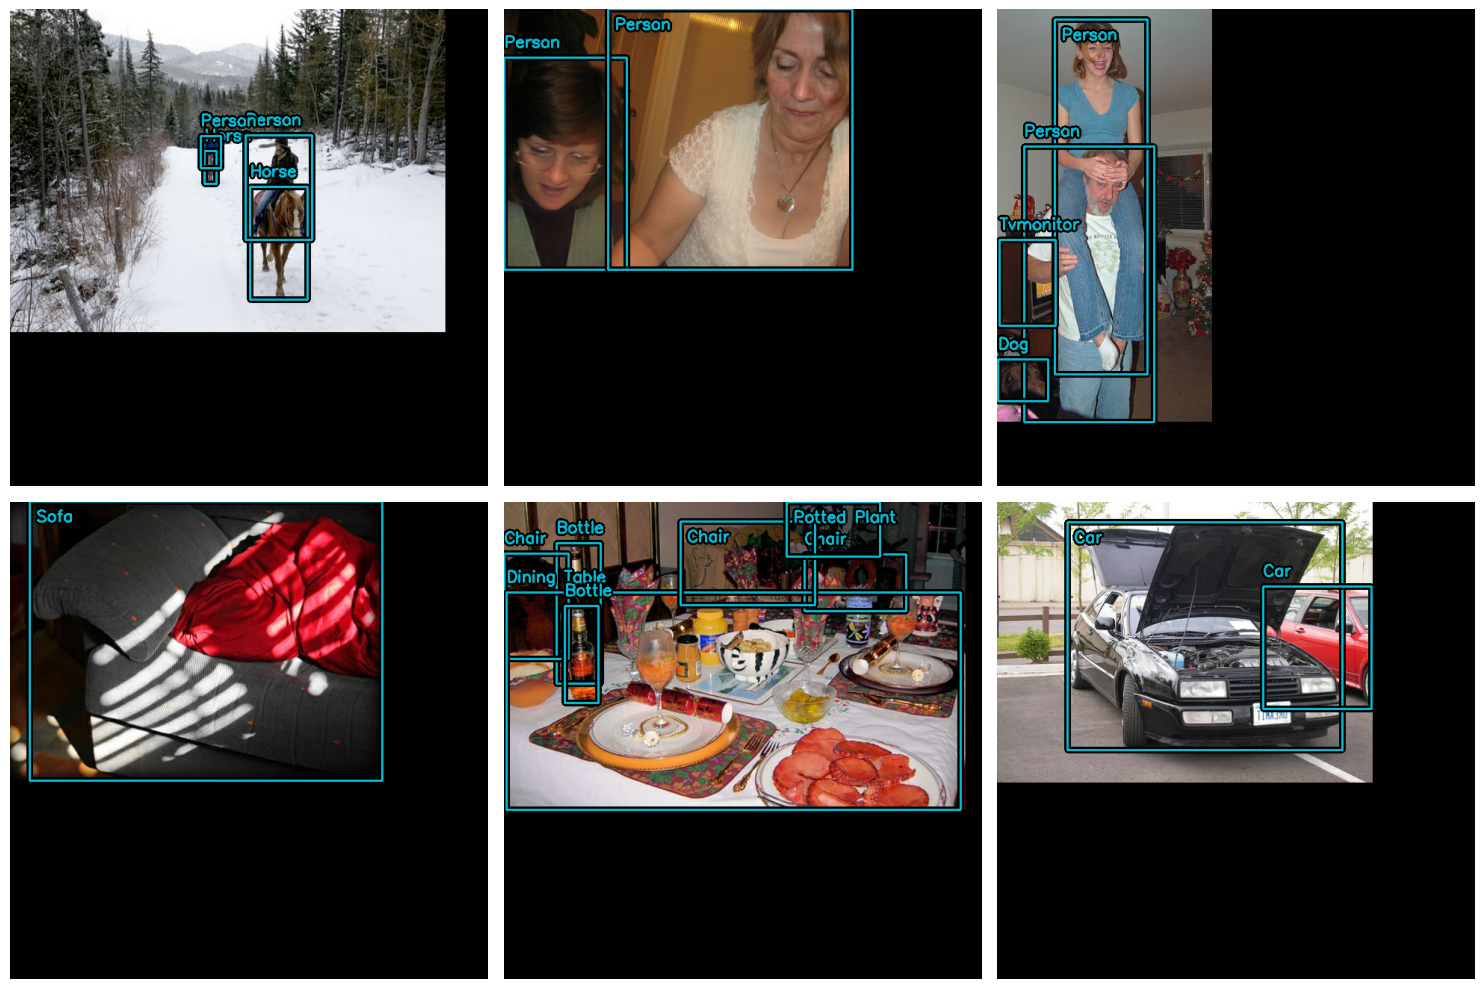

In [18]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=3
)

In [19]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

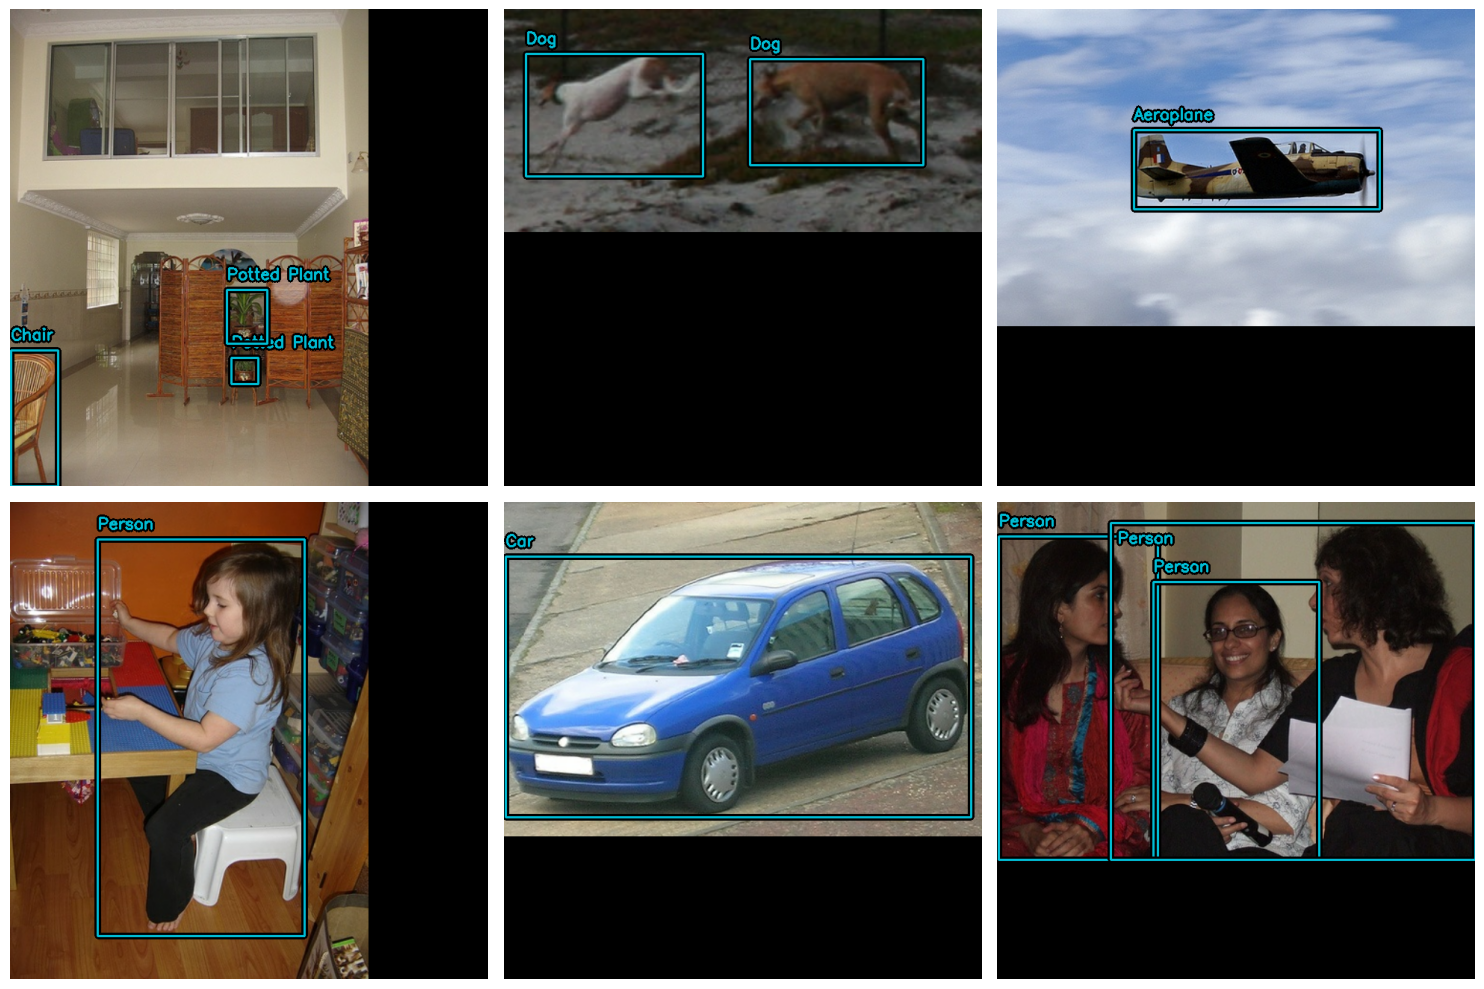

In [20]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=3
)

In [21]:

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)

### Optimizer, Loss Functions, Metric Evaluation

In [22]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [23]:
pretrained_model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

In [24]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds.take(20), bounding_box_format="xywh"
)

In [25]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    bounding_box_format="xywh",
    num_classes=20,
)

100%|██████████| 777/777 [00:00<00:00, 319kB/s]
100%|██████████| 90.3M/90.3M [00:00<00:00, 131MB/s]


In [26]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

### Fitting Model

In [ ]:
model.fit(
    train_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[coco_metrics_callback],
)

 2/20 ━━━━━━━━━━━━━━━━━━━━ 59:12 197s/step - loss: 409.4442  

In [ ]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

In [ ]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=3,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


In [ ]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

In [ ]:

class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model, bounding_box_format="xywh", dataset=visualization_ds
        )
